# E1. Localization

### Define all the imports
Import all the dependencies required to launch the notebook

In [334]:
# Import main dependencies
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [335]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
# Ignore warnings from pandas
pd.set_option('mode.chained_assignment', None)

In [336]:
# Import methods from our local library
from src.localization.PF import ParticleFilter
from src.localization.EKF import ExtendedKalmanFilter

### Set dataset

In [337]:
# Define the dataset to be used for the following tests. 
dataset = "data/MRCLAM_Dataset4" # Dataset
end_frame = 10000 # Extension of the dataset
robot = 'Robot5' # Robot

### T1. Review EKF localization
Review the ExtendedKalmanFilter() method, execute the EKF localization of the next code block, and answer the questions below:

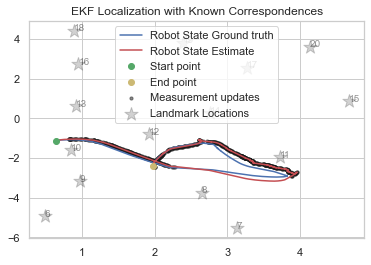

In [338]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([1.0, 1.0, 10.0]))** 2
Q = np.diagflat(np.array([300, 300, 1e16]))** 2
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q)

**T11** The EKF localisation algorithm iteratively executes the functions motion_update() and measurement_update() to propagate the robot's state estimate. Could you specify, respectively for each of the two functions, when are they called and what is their purpose?

(Answer here max 150 words)
#### motion_update()
- called whenever there is odometry data available. This happens when the robot moves, and it gets data on its motion (e.g. forward movement or rotation)
- Purpose: predict the robot’s next state based on the current state and the motion data

#### measurement_update() 
-  is called whenever there is sensor measurement data available. This happens when the robot receives information from its sensors about the environment
- Purpose: to correct the robot’s predicted state (from the motion update) based on the new sensor information

**T12** The ExtendedKalmanFilter() method inputs the R and Q matrices. Could you describe what are they used for and how they affect to the resulting localization estimation?

(Answer here max 150 words)

#### R Matrix: Process Noise Covariance Matrix
- the uncertainty in the robot’s motion model during the prediction (motion update) step
- is added to the state covariance matrix after each motion update
- lager values in R: indicate a higher uncertainty in the robot's motion model --> cause the EKF to place less trust in the predicted state, leading to a larger predicted state covariance 
- smaller values in R: indicate robot’s motion model is more reliable and accurate --> EKF will place more trust in the predicted state, leading to a smaller predicted state covariance

####  Q Matrix: Measurement Noise Covariance Matrix
- accounts for the uncertainty in the robot’s sensor model during the correction (measurement update) step
- quantifies how much we trust the sensor measurements
- lager values in Q: indicate a higher uncertainty in the sensor measurements --> EKF will place less trust in the measurements, relying more on the predicted state from the motion model
- smaller values in Q: indicate that the sensor measurements are more accurate and reliable --> The EKF will place more trust in the sensor data --> smaller state covariance after correction

### T2. Review PF localization
Review the ParticleFilter() method and execute the PF localization of the next code block. Then answer the questions below:

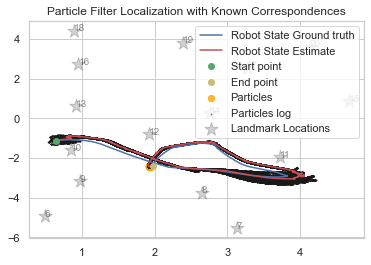

In [339]:
# Build Particle Filter object
num_particles = 20
motion_noise = np.array([0.1, 0.1, 0.1, 0.2, 0.2]) # Motion model noise [noise_x, noise_y, noise_theta, noise_v, noise_w]
measurement_noise = np.array([0.1, 0.1]) # Measurement model noise (in meters / rad) [noise_range, noise_bearing]
pf = ParticleFilter(dataset, robot, end_frame, num_particles, motion_noise, measurement_noise, True)

**T2.1** The PF localisation algorithm iteratively executes the functions motion_update(), measurement_update(), importance_sampling() and state_update(). Could you specify, the goal of each of the functions?

(Answer here max 150 words)

#### motion_update()
- goal: To propagate the particles based on the robot’s motion. It applies the motion model to each particle, predicting where the robot might be after a time step given the control inputs (odometry data).

#### measurement_update()
- goal: To evaluate how well each particle matches the observed sensor measurements. It computes the likelihood (weight) of each particle based on how closely the predicted sensor reading (based on the particle's state) matches the actual sensor reading.

#### importance_sampling()
- goal: To resample the particles according to their weights. Particles with higher weights (those that are more consistent with the actual sensor data) are more likely to be selected, while particles with lower weights may be discarded.

#### state_update()
- goal: To compute the robot’s estimated state based on the current set of particles. It does this by taking the mean of all the particles.

**T2.1** The ParticleFilter() method inputs three different configuration parameters: num_particles, motion_noise, measurement_noise. Could you describe purpose and how they affect to the resulting estimation?

(Answer here max 150 words)

####  num_particles
- determines the number of particles used to represent the distribution of possible robot states (position and orientation). Each particle is a hypothesis about where the robot might be.
- Affects the accuracy and computational cost. More particles improve accuracy but the computational cost is higher

####  motion_noise
- represents the uncertainty in the robot’s motion model. It describes how much noise is present in the robot's motion due to imperfect control.
- Higher motion noise causes the particles to spread out more
- lower motion noise keeps them closer to the predicted state

####  measurement_noise
- represents the uncertainty in the robot’s sensor measurements. It describes how much error is present in the data.
- Affects how much trust is placed in the sensor data. Higher measurement noise reduces the influence of sensor data
- lower measurement noise makes the filter more responsive to sensor readings

### T3. Benchmark
Compare the EKF and the PF algorithms using diferent configurations for each algorithm and different datasets. For the comparison use the error metric introducced in previous lab sessions. You may also want to use the measurement density metric from the first lab to characterize the datasets complexity. 

The objective of this task is to be able to determine the localization algorithm and configuration that provides the best performance. In order to decide which model and configuration works best follow the next steps:
1. Extract the benchmark metrics for each dataset and model configuaration.
2. Represent the results in different types of plots (for instance catplot or correlation matrix).
3. Analyze the results and extract conclusions.


#### Extract error metrics

In [340]:
from src.data.reader import Reader
# Code from Lab0
def build_timeseries(data,cols):
    timeseries = pd.DataFrame(data, columns=cols)
    timeseries['stamp'] = pd.to_datetime(timeseries['stamp'], unit='s')
    timeseries = timeseries.set_index('stamp')
    return timeseries

def filter_static_landmarks(lm, barcodes):
    for L,l in dict(barcodes).items(): # Translate barcode num to landmark num
        lm[lm==l]=L
    lm = lm[lm.type > 5] # Keep only static landmarks 
    return lm 


In [341]:
datasets = ["./data/MRCLAM_Dataset1",
            "./data/MRCLAM_Dataset2",
            "./data/MRCLAM_Dataset3",
            "./data/MRCLAM_Dataset4"]

robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

errors = pd.DataFrame(columns=['dataset', 'robot', 'model_name'])

# I tried out more than these configurations, 
# but because of the long computational time I focused on these
ekf_configs = [
    (np.diag([1, 1, 1.0])**2, np.diag([300, 300, 1e16])**2),
    (np.diag([1, 1, 10.0])**2, np.diag([1000, 1000, 1e20])**2),
    (np.diag([0.1, 0.1, 10.0])**2, np.diag([500, 500, 1e15])**2),
    (np.diag([100, 100, 100.0])**2, np.diag([50, 50, 1e15])**2),
]

pf_configs = [
    (1, np.array([0.1, 0.1, 0.1, 0.2, 0.2]), np.array([0.1, 0.1])),
    (10, np.array([0.2, 0.2, 0.2, 0.2, 0.2]), np.array([1, 1])),
    (10, np.array([0.2, 0.2, 0.2, 0.2, 0.2]), np.array([0.01, 0.01])),
    (10, np.array([0.2, 0.2, 0.2, 0.2, 0.2]), np.array([0.1, 0.1])),
    (10, np.array([1, 1, 1, 1, 1]), np.array([0.1, 0.1])),
    (50, np.array([0.1, 0.1, 0.1, 0.2, 0.2]), np.array([0.1, 0.1]))
]

def compute_error_metrics(data):
    # Calculate Euclidean distance between (x, y) and (x_gt, y_gt)
    eucl_dist = np.sqrt((data['x'] - data['x_gt'])**2 + (data['y'] - data['y_gt'])**2) 
    
    # mean distance error
    mean_error = np.mean(eucl_dist)
    
    # maximum error
    max_error = np.max(eucl_dist)
    
    return mean_error, max_error



def convert_to_dataframe(states, gt):
    df_states = pd.DataFrame(states, columns=['stamp', 'x', 'y', 'theta'])
    df_gt = pd.DataFrame(gt, columns=['stamp', 'x_gt', 'y_gt', 'theta_gt'])
    merged_data = df_states.merge(df_gt, on='stamp', how='inner')
    
    return merged_data

def compute_measurement_density(model, landmarks):
    #Mean number of measures per unit of distance
    traveled_distance = np.sum(
        np.sqrt(
            (model.groundtruth_data[1:, 1] - model.groundtruth_data[:-1, 1])**2 + 
            (model.groundtruth_data[1:, 2] - model.groundtruth_data[:-1, 2])**2
        )
    )
    # to avoid division by zero
    if traveled_distance > 0:
        number_landmarks = landmarks.shape[0]
        return number_landmarks / traveled_distance
    else:
        return 0


errors_list = []

for ds in datasets:
   for rob in robots:
        
        #load data
        self = Reader(ds, rob, end_frame)
        measurements = build_timeseries(self.data, cols=['stamp','type','range_l','bearing_l'])
        landmarks = measurements[measurements.type != -1]
        landmarks = filter_static_landmarks(landmarks, self.barcodes_data)
        
        # Compute models for EKF
        for i, (R, Q) in enumerate(ekf_configs):
            start_time = time.time()
            ekf_model = ExtendedKalmanFilter(dataset=ds, robot=rob, end_frame=end_frame, R=R, Q=Q, plot=False)
       

            data_ekf = convert_to_dataframe(ekf_model.states, ekf_model.groundtruth_data)       
            # Compute ATE for EKF
            ekf_mean_error, ekf_max_error = compute_error_metrics(data_ekf)

            end_time = time.time()
            computation_time_ekf = end_time - start_time

            measurement_density_ekf = compute_measurement_density(ekf_model, landmarks)
            
            errors_list.append({
                'dataset': ds, 
                'robot': rob, 
                'model_name': f'EKF_Config_{i+1}', 
                'mean_error': ekf_mean_error,
                'max_error': ekf_max_error,
                'computation_time': computation_time_ekf,
                'measurement_density': measurement_density_ekf
            })

        # Compute models for PF
        for i, (num_particles, motion_noise, measurement_noise) in enumerate(pf_configs):
            start_time = time.time() 
            pf_model = ParticleFilter(dataset=ds, robot=rob, end_frame=end_frame, num_particles=num_particles, 
                                      motion_noise=motion_noise, measurement_noise=measurement_noise, plot=False)
            
            # Convert numpy arrays (states and ground truth) to pandas DataFrame
            data_pf = convert_to_dataframe(pf_model.states, pf_model.groundtruth_data)
            
            # Compute ATE for PF
            pf_mean_error, pf_max_error = compute_error_metrics(data_pf)

            end_time = time.time()
            computation_time_pf = end_time - start_time
            measurement_density_pf = compute_measurement_density(pf_model, landmarks)
            
            errors_list.append({
                'dataset': ds, 
                'robot': rob, 
                'model_name': f'PF_Config_{i+1}', 
                'mean_error': pf_mean_error,
                'max_error': pf_max_error,
                'computation_time': computation_time_pf,
                'measurement_density': measurement_density_pf
            })

errors = pd.DataFrame(errors_list)
pd.set_option('display.max_rows', None)    
pd.set_option('display.max_columns', None)  

print(errors)




                    dataset   robot    model_name  mean_error  max_error  \
0    ./data/MRCLAM_Dataset1  Robot1  EKF_Config_1    0.593929   1.375293   
1    ./data/MRCLAM_Dataset1  Robot1  EKF_Config_2    0.624860   1.562661   
2    ./data/MRCLAM_Dataset1  Robot1  EKF_Config_3    0.668923   1.678101   
3    ./data/MRCLAM_Dataset1  Robot1  EKF_Config_4    0.712387   3.543481   
4    ./data/MRCLAM_Dataset1  Robot1   PF_Config_1    2.173366   3.911661   
5    ./data/MRCLAM_Dataset1  Robot1   PF_Config_2    0.330158   0.548427   
6    ./data/MRCLAM_Dataset1  Robot1   PF_Config_3    0.104285   0.323130   
7    ./data/MRCLAM_Dataset1  Robot1   PF_Config_4    0.175197   0.451667   
8    ./data/MRCLAM_Dataset1  Robot1   PF_Config_5    0.426659   2.829524   
9    ./data/MRCLAM_Dataset1  Robot1   PF_Config_6    0.187858   0.520795   
10   ./data/MRCLAM_Dataset1  Robot2  EKF_Config_1    0.140073   0.455359   
11   ./data/MRCLAM_Dataset1  Robot2  EKF_Config_2    0.166784   0.645132   
12   ./data/

#### Represent metrics
For instance you could use the catplot of the seaborn library. Feel free to use another informative plot.

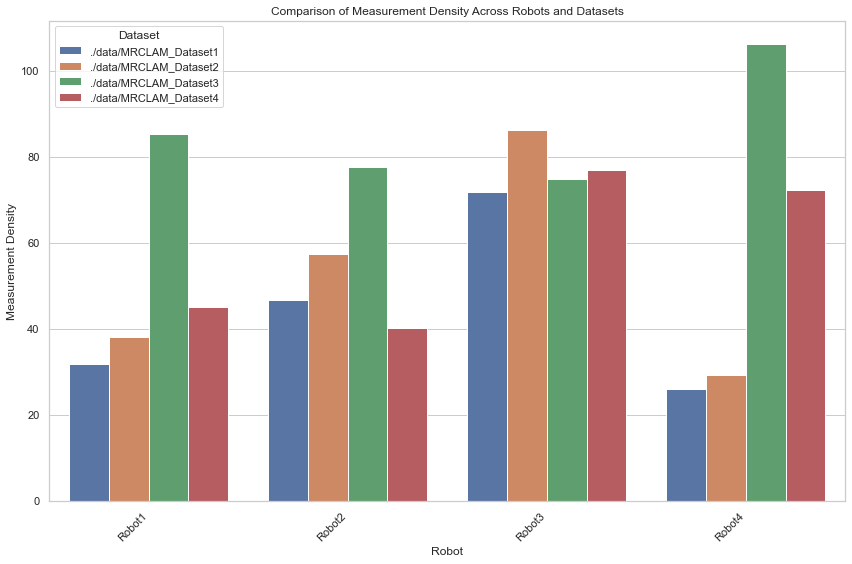

In [342]:
# Plot measurement density for each robot and dataset

unique_density = errors[['dataset', 'robot', 'measurement_density']].drop_duplicates()

plt.figure(figsize=(12, 8))
sns.barplot(x='robot', y='measurement_density', hue='dataset', data=unique_density)

plt.xlabel('Robot')
plt.ylabel('Measurement Density')
plt.title('Comparison of Measurement Density Across Robots and Datasets')

plt.xticks(rotation=45, ha="right")

plt.legend(title='Dataset')

plt.tight_layout()
plt.show()

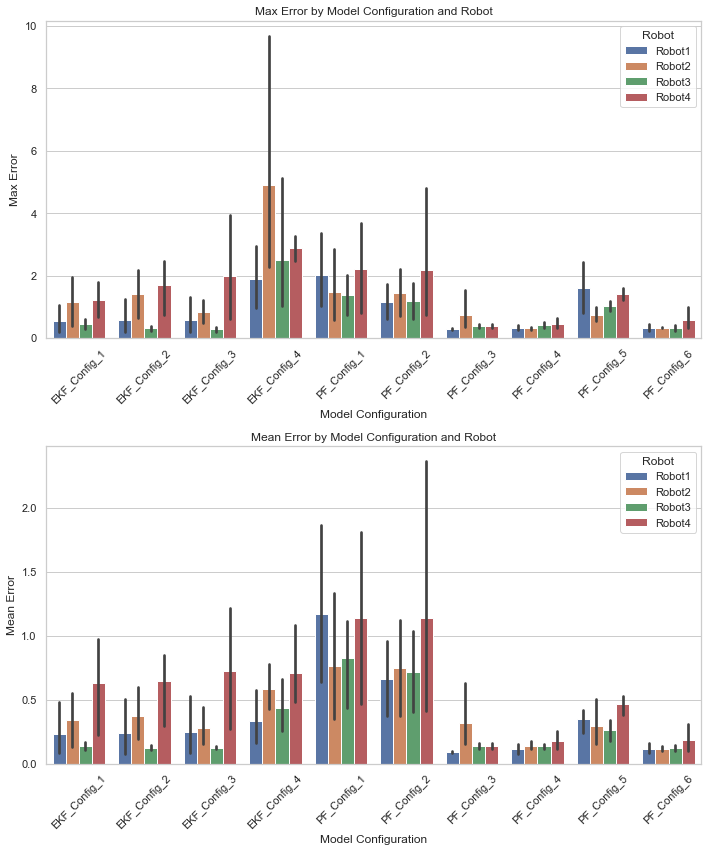

In [343]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12)) 

# Max Error Plot
sns.barplot(
    data=errors, 
    x="model_name", y="max_error", hue="robot",
    ax=axes[0]
)
axes[0].set_title("Max Error by Model Configuration and Robot")
axes[0].set_xlabel("Model Configuration")
axes[0].set_ylabel("Max Error")
axes[0].legend(title="Robot")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Mean Error Plot
sns.barplot(
    data=errors, 
    x="model_name", y="mean_error", hue="robot",
    ax=axes[1]
)
axes[1].set_title("Mean Error by Model Configuration and Robot")
axes[1].set_xlabel("Model Configuration")
axes[1].set_ylabel("Mean Error")
axes[1].legend(title="Robot")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


plt.tight_layout()

plt.show()

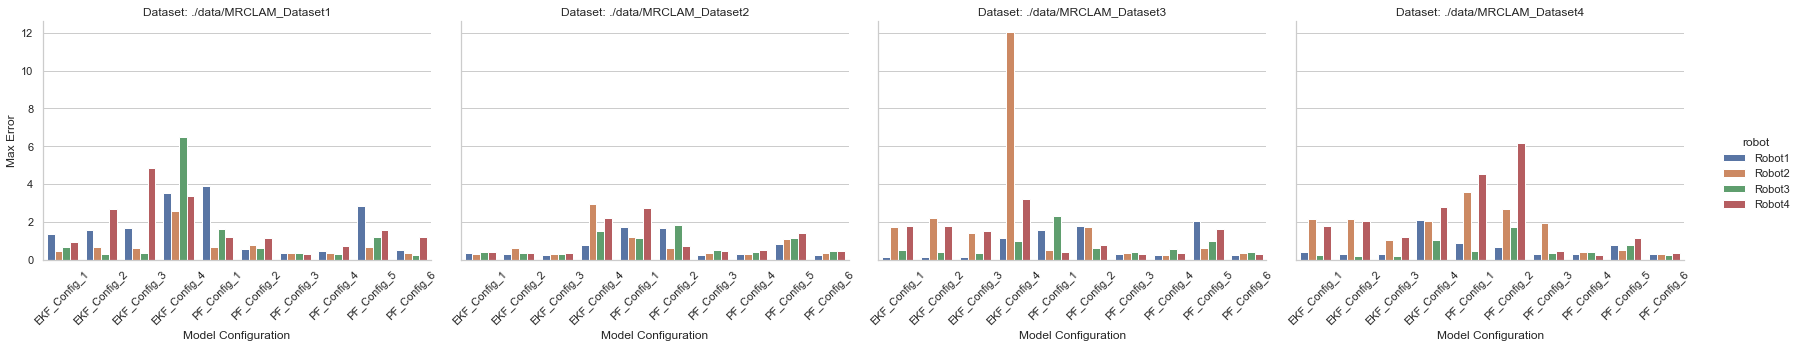

In [344]:
# Represent metrics for all experiments
catplot = sns.catplot(
    data=errors, kind="bar", 
    x="model_name", y="max_error", hue="robot",
    col="dataset", height=5, aspect=1.2
)

catplot.set_axis_labels("Model Configuration", "Max Error")
catplot.set_titles("Dataset: {col_name}")

for ax in catplot.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

catplot.tight_layout()


plt.show()



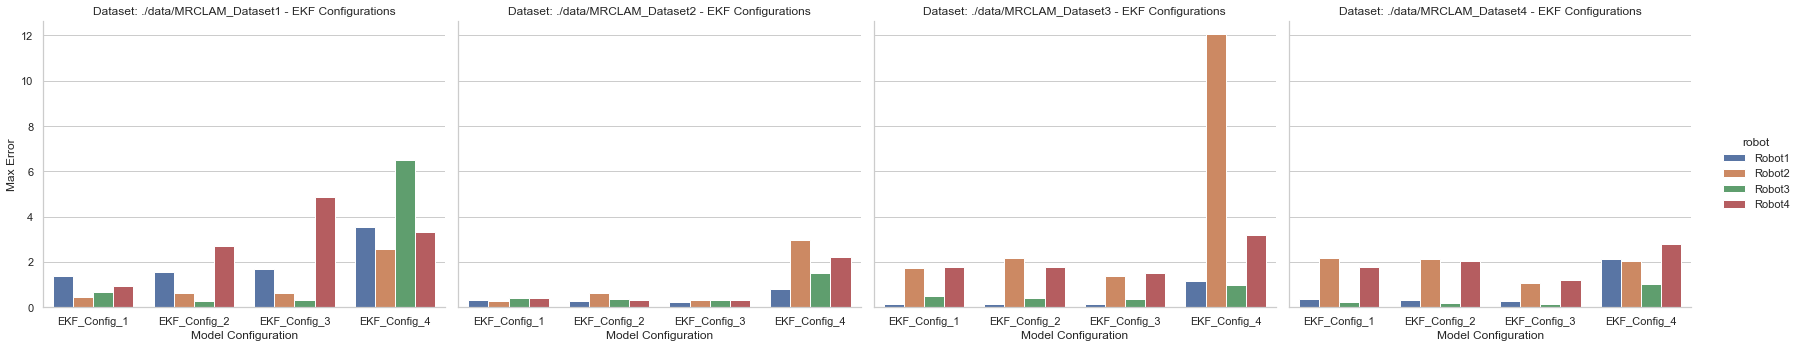

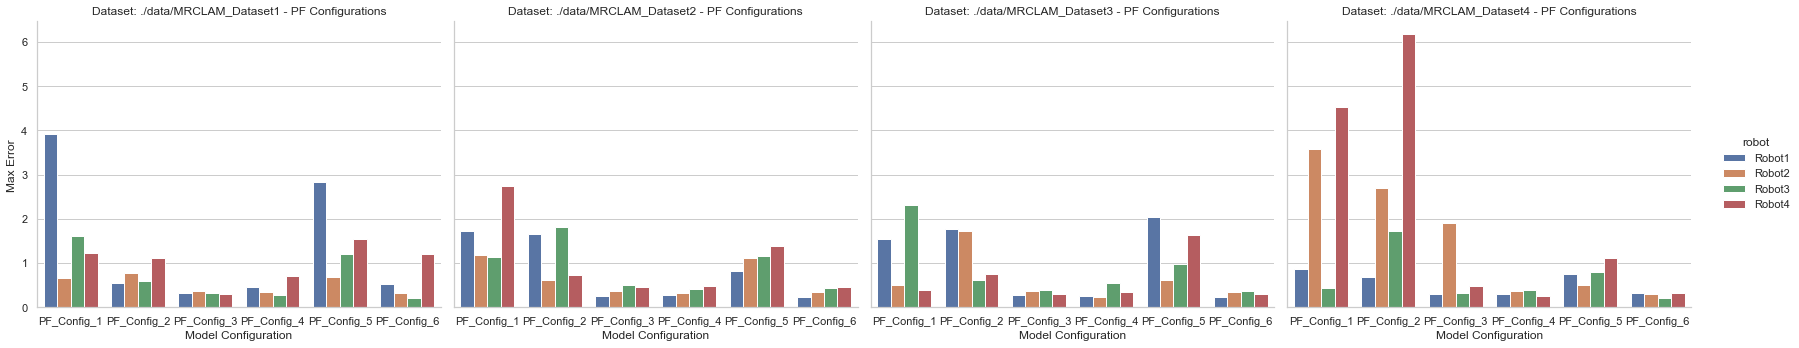

In [345]:
#For a better overview I plot the data into two separate figures

ekf_errors = errors[errors['model_name'].str.contains('EKF')]
pf_errors = errors[errors['model_name'].str.contains('PF')]

# Plot for EKF configurations
catplot_ekf = sns.catplot(
    data=ekf_errors, kind="bar", 
    x="model_name", y="max_error", hue="robot",
    col="dataset", height=5, aspect=1.2
)
catplot_ekf.set_axis_labels("Model Configuration", "Max Error")
catplot_ekf.set_titles("Dataset: {col_name} - EKF Configurations")
catplot_ekf.tight_layout()

plt.show()

# Plot for PF configurations
catplot_pf = sns.catplot(
    data=pf_errors, kind="bar", 
    x="model_name", y="max_error", hue="robot",
    col="dataset", height=5, aspect=1.2
)
catplot_pf.set_axis_labels("Model Configuration", "Max Error ")
catplot_pf.set_titles("Dataset: {col_name} - PF Configurations")
catplot_pf.tight_layout()

plt.show()

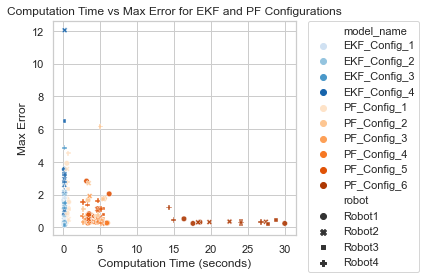

In [346]:
ekf_models = [name for name in errors['model_name'].unique() if "EKF" in name]
pf_models = [name for name in errors['model_name'].unique() if "PF" in name]

# Define two different color palettes
ekf_palette = sns.color_palette("Blues", len(ekf_models))  # Blue shades for EKF models
pf_palette = sns.color_palette("Oranges", len(pf_models))  # Orange shades for PF models


palette = dict(zip(ekf_models + pf_models, ekf_palette + pf_palette))

sns.scatterplot(
    data=errors, 
    x='computation_time', y='max_error', 
    hue='model_name', style='robot', 
    palette=palette, 
    s=30, alpha=0.9 
)

plt.title("Computation Time vs Max Error for EKF and PF Configurations")
plt.xlabel("Computation Time (seconds)")
plt.ylabel("Max Error")


plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0.)

plt.tight_layout()
plt.show()

#### Analize metrics
**T3.1** Analize the representations, and extract some conclusions regarding the performance of each of the model configurations used. Which would be the best suited method for offline execution? Why?


(Answer here max 300 words)
#### EKF
- Low/Moderate process and measurement noise (EKF_Config_1) offers the most balanced and accurate performance. It consistently shows lower max error and mean error, while maintaining low computation times
- High process noise (EKF_Config_4) leads to significant errors --> make the filter less certain about the robot’s own motion --> inaccurate predictions
- very high measurement noise (EKF_Config_2 with [1000, 1000, 1e20]) makes the filter more skeptical of the sensor measurements
--> greater reliance on the motion model 
--> However, in cases where the motion model is inaccurate, this can lead to larger errors (can be seen in error spikes for certain datasets)
- low state noise with moderate measurement noise (EKF_Config_3) also performs well but slightly less consistently than EKF_Config_1

#### PF
Number of Particles:
- PF_Config_1, with only 1 particle, performs poorly
- Higher particle counts (PF_Config_6) lead to more accurate results (but have a higher computation time)

Motion Noise:
- PF_Config_5 with high motion noise, which leads to significant errors
--> makes filter more uncertain about the robot's movement
- PF_Config_3 and PF_Config_6, with moderate noise are better
--> filter can more accurately model the robot’s true state without too much uncertainty

Measurement Noise:
- Lower measurement noise (PF_Config_3 and PF_Config_6) generally results in better performance, as the filter can correct for errors more effectively.
- High motion noise (PF_Config_5) degrades performance significantly

#### Best-suited Method:
For offline execution, Particle Filters (PF), especially configurations with higher particle counts, are generally better suited. While they require more computation time, they tend to provide higher accuracy in terms of both max error and mean error. Configurations like PF_Config_4 or PF_Config_6 balance accuracy and consistency across datasets, making them ideal for offline tasks where precision is crucial, and time is less .


**T3.2** Which would be the best suited method for online execution? Try to add the computation time as an extra metric for the assessment.

(Answer here max 150 words)
#### Best-suited Method:
Extended Kalman Filters (EKF) are the best-suited method for online execution, because of the significantly lower computation time. 
Sometimes PF configurations can achieve better accuracy, but as you can see in the plot "Computation Time vs max error for EKF and PF Configurations" the EKF models are much faster ans with the right configuration can still have a good accuracy. For example, EKF models like EKF_Config_1 and EKF_Config_3.

**T3.3** BONUS. How would you modify the PF filter to allow filter initialization without prior state belief?

(Answer here max 150 words)

Without prior state belief, I would initialize the particles uniformly
- Therefore you need to define boundaries (e.g., possible ranges of positions)
- sample particles uniformly from the previously definded range




**Delivery Instructions:**

1. 📂 Please download your work in both Notebook and Markdown formats. Simply navigate to: 

   - `File` > `Download as` > `Notebook`

   - `File` > `Download as` > `Markdown`
   

2. 🗜 Once you have the necessary files and any associated figures, kindly compress them into a single .zip file. When naming your file, please use the format: **E1_FirstName_LastName.zip**.


3. 📤 Finally, make sure to upload your .zip file to Aula Digital by the set deadline: **15/10/24**.

Best of luck with your submission, and reach out if you have any questions!
